In [1]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from filterpy.stats import (covariance_ellipse, 
                            plot_covariance_ellipse, plot_covariance)
import matplotlib
import matplotlib.ticker as tck

from scipy.integrate import solve_ivp 
from numba import jit
#from numbalsoda import lsoda_sig, lsoda
from numba import njit, cfunc
import time

matplotlib.rcParams["xtick.labelsize"]=18
matplotlib.rcParams["ytick.labelsize"]=18 
matplotlib.rcParams["axes.labelsize"]=20
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

%matplotlib inline


## The ANAC4 system 
The ANAC4 system is a second-order differential equation which can be written as a coupled system of first order differential equation designed to mimic the behaviour of sawtooth oscillations. It is written 
\begin{align} 
    \dot{a} &= v,\\
    \dot{v} &= \mu a + 2 \sigma a^3. 
\end{align}
For this notebook, we will use the value $\mu = 10$ and $\sigma =-0.1$ to generate the observational data. This generates a symmetry breaking solution where the particle can get trapped in one side of the potential well for specific initial conditions. 

## Designing the State Covariance 
When initialising the ensemble Kalman filter, we must make some assumption about the multivariate Guassian covariance matrix $\boldsymbol{P}$. Here we are specifying the initial value for the variance of this Guassian distribution. In 2D this is simply 
\begin{equation}
    \boldsymbol{P} = 
    \begin{bmatrix}
        \sigma_{xx}^2 & \sigma_{xy}^2 \\
        \sigma_{yx}^2 & \sigma_{yy}^2 
    \end{bmatrix}
\end{equation}
If we are relatively uncertain about our initial estimates, then the standard deviation is set larger. If we expect some maximum value in one of the measurements, then we can set it to be 3 standard deviations. 

When considering the ANAC4 system we may wish to allow the Kalman filter to find the parameters $\mu$ and $\bar{\sigma}$. In this case the covariance matrix will be
\begin{equation}
    \boldsymbol{P} = 
    \begin{bmatrix}
        \sigma_{xx}^2 & \sigma_{xy}^2 & 0 & 0 \\
        \sigma_{yx}^2 & \sigma_{yy}^2 & 0 & 0\\
        0 & 0 & \sigma^2_{\mu\mu} & \sigma^2_{\mu \bar{\sigma}}\\
        0 & 0 & \sigma^2_{\bar{\sigma} \mu} & \sigma^2_{\bar{\sigma} \bar{\sigma}} 
    \end{bmatrix}
\end{equation}
where I have assumed that there is no correlation between the parameters and the variables of the ODE. In reality, the Kalman filter will probably decided that there is. If we set this to some scaled version of the identity matrix, then we are assuming no relationship between the variables. 

Observational data characteristics
Period 2.0689655172413794
Samples per period 413


Text(0, 0.5, '$\\dot{a}$')

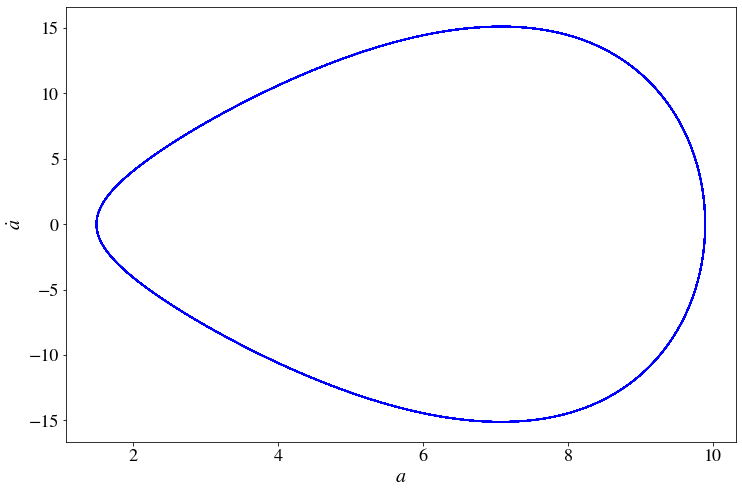

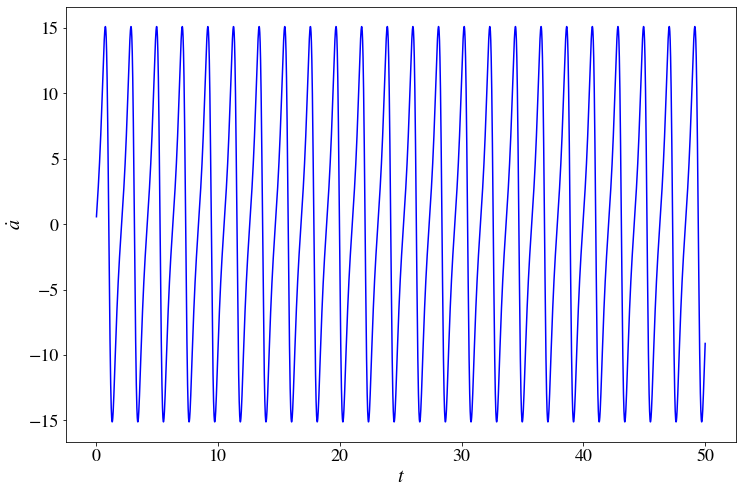

In [2]:

@jit
def anac(x, dt):
    return np.array([x[1], x[2]*x[0] + 2*x[3]*x[0]**3, 0, 0])

@jit
def van_der_pol(x,dt):
    return np.array([x[1], x[2]*(1-[x[0]**2])*x[1] - x[0]])

@jit
def runge_fx(x, dt):
    
    k1 = anac(x, dt)
    k2 = anac(x + 0.5*dt*k1, dt)
    k3 = anac(x + 0.5*dt*k2, dt )
    k4 = anac(x + dt*k3, dt)
    x = x + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return x
    

# Generate synthetic data
def generate_data(steps, x0 = np.array([1.5, 1.,10., -0.1]), dt_phase_model=0.01, std=0.1):
    np.random.seed(1234) #this isn't how you should set the seed now
    observations = np.zeros((steps,x0.shape[0]))
    observation_times = []
    tcounter = 0
    for i in range(steps):
        #x0 = runge_kutta(fx, x0, dt_phase_model)
        x0 = runge_fx(x0, dt_phase_model)
        tcounter+=dt_phase_model
        observation_times.append(tcounter)
        observations[i] = x0 #+ np.random.normal(0,std, size=x0.shape[0])

    for i in range(x0.shape[0]):
        observations[:,i]+=np.random.normal(0,std, size=steps)
    return observations, np.array(observation_times)


Observational data characteristics
Period 2.0689655172413794
Samples per period 16


Text(0, 0.5, '$\\dot{a}$')

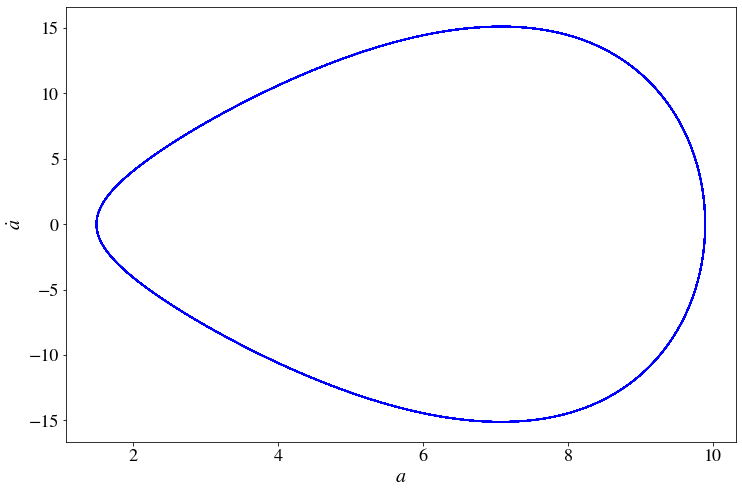

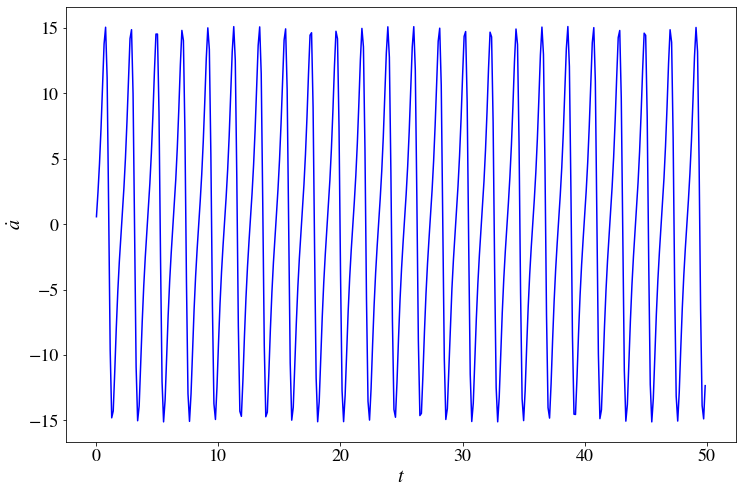

In [8]:
true_params = [10, -0.1] #true model parameters
std = 0.1 #standard deviation of additive noise
# Parameters
dt_assim = 0.01
dt_phase_model = 0.005
steps = 10000

# Generate synthetic data
observations, observation_times = generate_data(steps,
                                                x0 = np.array([1.5, 
                                                               0.5, 
                                                               10, -0.1 ]),
                                                dt_phase_model=dt_phase_model, std=0)


plt.figure(figsize=(12,8))
plt.plot(observations[:,0], observations[:,1], "b") 
plt.xlabel(r"$a$")
plt.ylabel(r"$\dot{a}$")

########### downsample the data

#enkf.Q[:3,:3] = Q
observation_sub = 25
period=2.0689655172413794
observations= observations[::observation_sub,:2]

observation_times = observation_times[::observation_sub] 
observational_nu =int(period//(dt_phase_model*observation_sub))

print("Observational data characteristics")
print("Period", period)
print("Samples per period", observational_nu)

plt.figure(figsize=(12,8))
plt.plot(observation_times, observations[:,1], "b") 
plt.xlabel(r"$t$")
plt.ylabel(r"$\dot{a}$")

### Assimilation with the ANAC model 
We demonstrate the full functionality of the code by first assimilating observations from the ANAC model above which can be made noiser or sparser. 

For EnKF, we must specify 

In [15]:
#define the observation operator (only adot) 
def hx(x):
    return [x[0], x[1]]  

np.random.seed(1)
initial_covariance = np.eye(4) *9
initial_covariance[-1, -1] = 1

perturb = np.random.uniform(low=-1, high=1, size= 4)
initial_state = np.array([1.5, 0.5, 10, -0.1]) + perturb

print("True initial condition") 
print([1.5, 1,10., -0.1])
print("Perturbed initial condition") 
print(initial_state) 

# Ensemble Kalman Filter setup
enkf = EnKF(x=initial_state, #initial mean
            inf=1, #inflation factor (added in CCFE code) 
            inf_a = None, #analysis inflation
            gauss_kick = None, #uniform process noise
            P=initial_covariance, #initial uncertainty
            dim_z=2, #number of observations
            dt=dt_phase_model, #integration time-step (not really used) 
            hx=hx, #observation function
            N=30, #number of ensemble members
            fx=runge_fx, #nonlinear SSM
            ensemble_type="gsn", #initial prior distribution
            constraints = None, #include tuple of counstraints
            seed=1
           )


Q = np.zeros((4,4)) #set the process noise to zero as in the CCFE code
enkf.Q = Q 
enkf.R = np.diag([10*std**2, 10*std**2]) #measuremement uncertainty

time_prediction = np.arange(0,observation_times[-1]+dt_phase_model, dt_phase_model)

# Run the filter
estimates = np.zeros((time_prediction.shape[0], initial_state.shape[0]))
estimates[0,:] = initial_state
Pmat = np.zeros((time_prediction.shape[0], initial_state.shape[0], initial_state.shape[0])) 
Pmat[0,:,:] = initial_covariance
update_counter = 0 

#perform filtering
for ii, t in enumerate(time_prediction[1:]) :

    #assimilate observations if they are considered contemporary 
    if np.isclose(t, observation_times[1:], rtol =1e-8, atol=dt_phase_model*1e-8).any():
        enkf.predict(True)
        enkf.update(observations[np.isclose(t, observation_times, rtol =1e-8,
                                            atol=dt_phase_model*1e-8),:][0])
        update_counter+=1

    #else integrate the ensemble members forward in time 
    else:
        enkf.predict(False)
    estimates[ii+1,:] = np.copy(enkf.x)  # Extract only state variables from the state vector
    Pmat[ii+1,:,:] = np.copy(enkf.P)
    
print("updated", update_counter, "times") 
print("Final covariance P matrix") 
print(enkf.P) 

True initial condition
[1.5, 1, 10.0, -0.1]
Perturbed initial condition
[ 1.33404401  0.94064899  9.00022875 -0.49533485]
updated 399 times
Final covariance P matrix
[[ 9.87920640e-04 -2.01605734e-03 -3.27065399e-04  7.86045228e-06]
 [-2.01605734e-03  4.62105852e-03  3.26441426e-04 -9.73147412e-06]
 [-3.27065399e-04  3.26441426e-04  5.14898883e-04 -9.59652075e-06]
 [ 7.86045228e-06 -9.73147412e-06 -9.59652075e-06  2.13420619e-07]]


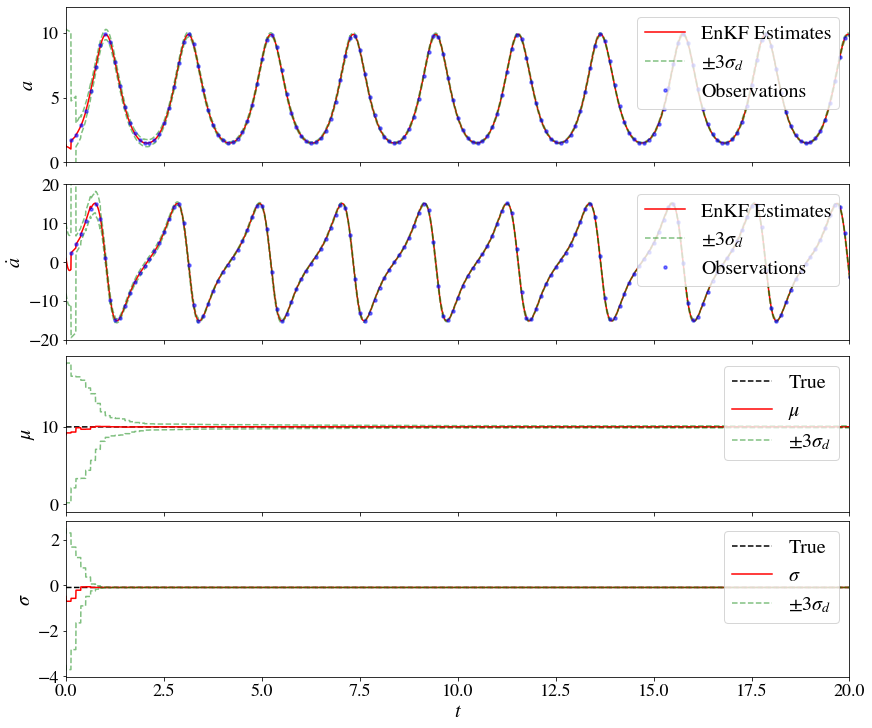

In [16]:
fig, ax = plt.subplots(4,1, figsize=(12, 10), sharex=True, layout="constrained")

ax[0].plot(time_prediction, estimates[:, 0], label='EnKF Estimates', color='r')

ax[0].plot(time_prediction, estimates[:, 0]+3*np.sqrt(Pmat[:,0,0]), color='g', 
          linestyle="--", alpha=0.5)
ax[0].plot(time_prediction, estimates[:, 0]-3*np.sqrt(Pmat[:,0,0]), color='g',
          linestyle="--", alpha=0.5, label=r"$\pm 3\sigma_d$")
ax[0].plot(observation_times[1:], observations[1:, 0], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
#ax[0].fill_between(range(len(estimates[:,0])), estimates[:, 0]+np.sqrt(Pmat[:,0,0]), 
#                  estimates[:, 0]-np.sqrt(Pmat[:,0,0]),
#                     facecolor='yellow', alpha=0.2, interpolate=True)
ax[0].legend(loc="upper right", fontsize=20)
ax[0].set_ylim((0,12))
ax[1].set_xlim((0, 20)) 
ax[0].set_ylabel(r"$a$")

ax[1].plot(time_prediction, estimates[:, 1], label='EnKF Estimates', color='r')
ax[1].plot(time_prediction, estimates[:, 1]+3*np.sqrt(Pmat[:,1,1]), color='g', 
          linestyle="--" , alpha=0.5)
ax[1].plot(time_prediction, estimates[:, 1]-3*np.sqrt(Pmat[:,1,1]), color='g',
          linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)

ax[1].plot(observation_times[1:], observations[1:, 1], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
ax[1].legend(loc="upper right", fontsize=20)
ax[1].set_ylabel(r"$\dot{a}$")
ax[1].set_ylim((-20,20))

colours = ["r", "b", "g"]
param_labels = [r"$\mu$", r"$\sigma$"]
for i in range(2):
    ax[i+2].plot(time_prediction, np.ones(estimates.shape[0])*true_params[i], "--k", 
                label="True")
    ax[i+2].plot(time_prediction, estimates[:,i+2], c="r", label = param_labels[i]) 
    ax[i+2].plot(time_prediction, estimates[:, i+2]+3*np.sqrt(Pmat[:,i+2,i+2]), color='g', 
          linestyle="--" , alpha=0.5)
    ax[i+2].plot(time_prediction, estimates[:, i+2]-3*np.sqrt(Pmat[:,i+2,i+2]), color='g',
              linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)
    ax[i+2].legend(loc="upper right", fontsize=20) 
ax[2].set_ylabel(r"$\mu$")
ax[3].set_ylabel(r"$\sigma$")
ax[3].set_xlabel(r"$t$")
plt.savefig("enkf_rewritten_figures/ANAC/two_state_measurement_larger_R.pdf", 
            bbox_inches="tight") 


## Single state observation of the ANAC model
We generate an example code to recreate previous results of the CCFE code. We generate observations from the ANAC model above and using observations of only $\dot{a}$ fit the state variables and the parameters.

Observational data characteristics
Period 2.0689655172413794
Samples per period 12


Text(0, 0.5, '$\\dot{a}$')

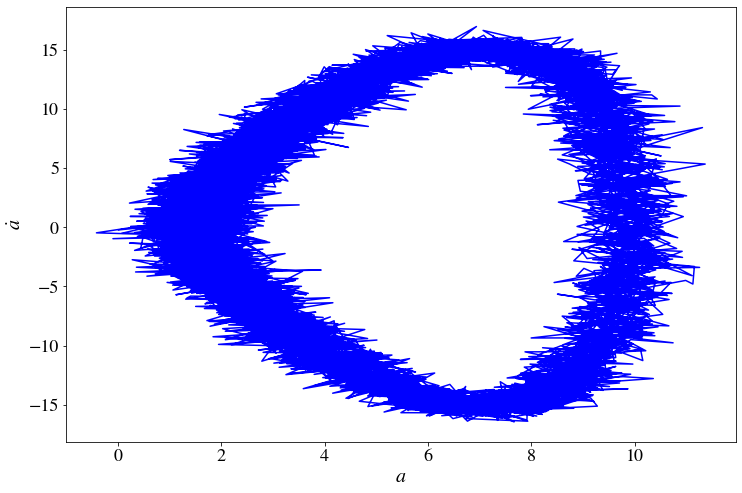

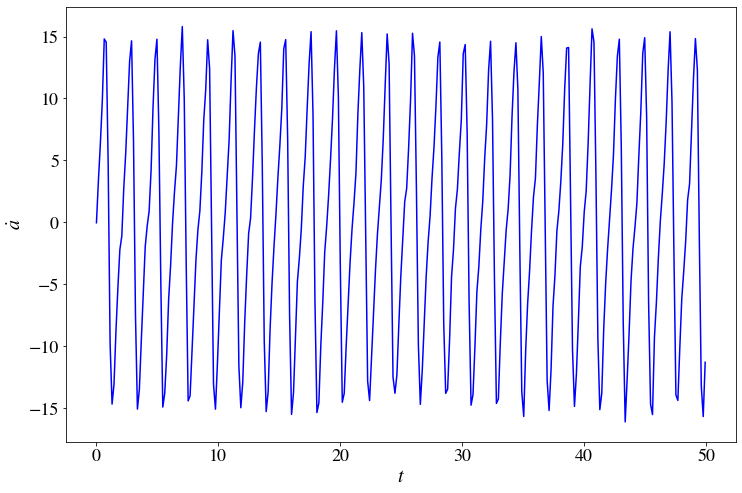

In [18]:

plt.close("all")
# Lorenz equations
@jit
def anac(x, dt):
    return np.array([x[1], x[2]*x[0] + 2*x[3]*x[0]**3, 0, 0])

@jit
def runge_fx(x, dt):
    
    k1 = anac(x, dt)
    k2 = anac(x + 0.5*dt*k1, dt)
    k3 = anac(x + 0.5*dt*k2, dt )
    k4 = anac(x + dt*k3, dt)
    x = x + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return x
    

# Generate synthetic data
def generate_data(steps, x0 = np.array([1.5, 1.,10., -0.1]), dt_phase_model=0.01, std=0.1):
    np.random.seed(1234)
    #x0 = np.array([1.5, 1.,10., 0.1])  # initial state and parameters
    observations = np.zeros((steps,x0.shape[0]))
    observation_times = []
    tcounter = 0
    for i in range(steps):
        #x0 = runge_kutta(fx, x0, dt_phase_model)
        x0 = runge_fx(x0, dt_phase_model)
        tcounter+=dt_phase_model
        observation_times.append(tcounter)
        observations[i] = x0 + np.random.normal(0,std, size=x0.shape[0])
    return observations, np.array(observation_times)

true_params = [10, -0.1]
std = 0.5 #standard deviation of additive noise
# Parameters
dt_assim = 0.01
dt_phase_model = 0.005
steps = 10000

# Generate synthetic data
observations, observation_times = generate_data(steps,
                                                x0 = np.array([1.5, 0.5, 10, -0.1]),
                                                dt_phase_model=dt_phase_model, std=std)


plt.figure(figsize=(12,8))
plt.plot(observations[:,0], observations[:,1], "b") 
plt.xlabel(r"$a$")
plt.ylabel(r"$\dot{a}$")

########### downsample the data

#enkf.Q[:3,:3] = Q
observation_sub = 32
period=2.0689655172413794
#observations= observations[::observation_sub,:2]
observations= np.reshape(observations[::observation_sub,1], 
                         (observations[::observation_sub,1].shape[0], 1))
observation_times = observation_times[::observation_sub] 
observational_nu =int(period//(dt_phase_model*observation_sub))

print("Observational data characteristics")
print("Period", period)
print("Samples per period", observational_nu)

plt.figure(figsize=(12,8))
plt.plot(observation_times, observations[:], "b") 
plt.xlabel(r"$t$")
plt.ylabel(r"$\dot{a}$")


In [26]:
#define the observation operator (only adot) 
def hx(x):
    return x[1] 
#13,  36, 141, 149, 165, 182
np.random.seed(3)
initial_covariance = np.eye(4) * 2
initial_covariance[-1, -1] = 1
perturb = np.random.uniform(low=-10, high=10, size= 4)
perturb[-1] = np.random.uniform(low=-1, high=1) #sigma perturbation must be limited as becomes unstable
initial_state = np.array([1.5, 1, 10., -0.5]) + perturb
 # perturb initial state and parameters
print("True initial condition") 
print([1.5, 1,10., -0.1])
print("Perturbed initial condition") 
print(initial_state) 
constraints = np.array([
                       [None, None, None, None],
                       [None, None, None, -1e-16]
                       ])

# Ensemble Kalman Filter setup
enkf = EnKF(x=initial_state, #initial mean
            inf=1.00, #inflation factor (added in CCFE code) 
            inf_a = None,
            P=initial_covariance, #initial uncertainty
            dim_z=1, #number of observations
            dt=dt_phase_model, #integration time-step (not really used) 
            hx=hx, #observation function
            N=30, #number of ensemble members
            fx=runge_fx, #nonlinear SSM
            ensemble_type="gsn",
            constraints = None, #constraints can be included on sigma if desired
            gauss_kick = None, 
            qscales = None
           )


Q = np.zeros((4,4)) #set the process noise to zero as in the CCFE code
# about when this is added

enkf.Q = Q 
enkf.Q[0,0] = 0
enkf.Q[1, 1] = 0 #Q_discrete_white_noise(2, dt=dt_phase_model, var=10) #need to be careful 
enkf.Q[2,2] = 0
enkf.Q[3,3] = 0

enkf.R = np.diag([std**2]) #measuremement uncertainty

time_prediction = np.arange(0,observation_times[-1], dt_phase_model)

# Run the filter
estimates = np.zeros((time_prediction.shape[0], initial_state.shape[0]))
Pmat = np.zeros((time_prediction.shape[0], initial_state.shape[0], initial_state.shape[0])) 
update_counter = 0 

#perform filtering
for ii, t in enumerate(time_prediction) :

    #assimilate observations if they are considered contemporary 
    if np.isclose(t, observation_times[1:], rtol =1e-8, atol=dt_phase_model*1e-8).any():
        enkf.predict(True)
        enkf.update(observations[np.isclose(t, observation_times, rtol =1e-8,
                                            atol=dt_phase_model*1e-8),:][0])
        update_counter+=1

    #else integrate the ensemble members forward in time 
    else:
        enkf.predict(False)
    estimates[ii,:] = np.copy(enkf.x)  # Extract only state variables from the state vector
    Pmat[ii,:,:] = np.copy(enkf.P)
    
print("updated", update_counter, "times") 
print("Final covariance P matrix") 
print(enkf.P) 

True initial condition
[1.5, 1, 10.0, -0.1]
Perturbed initial condition
[2.51595805 5.16295645 5.81809478 0.28589391]
updated 312 times
Final covariance P matrix
[[ 2.95652540e-03 -4.92749326e-03 -3.55389959e-04  4.50618235e-06]
 [-4.92749326e-03  1.02107525e-02  6.77596260e-05 -2.58873158e-06]
 [-3.55389959e-04  6.77596260e-05  8.85333749e-04 -1.35331495e-05]
 [ 4.50618235e-06 -2.58873158e-06 -1.35331495e-05  2.77936313e-07]]


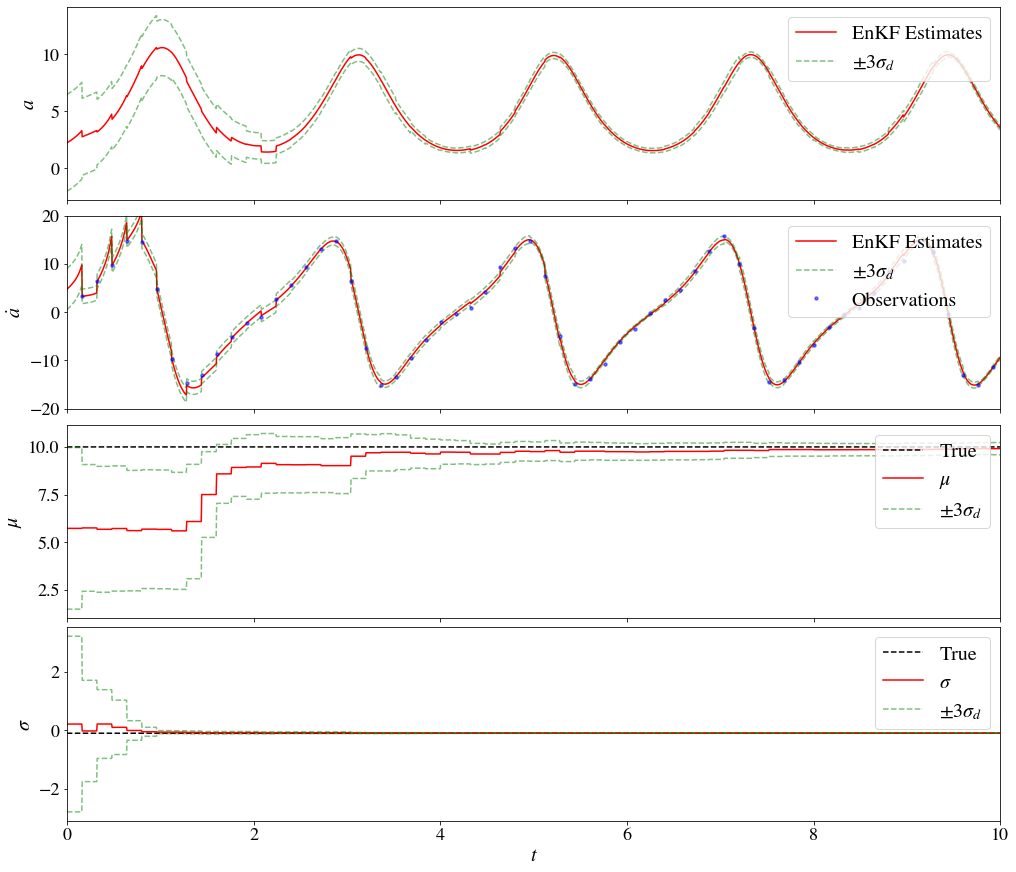

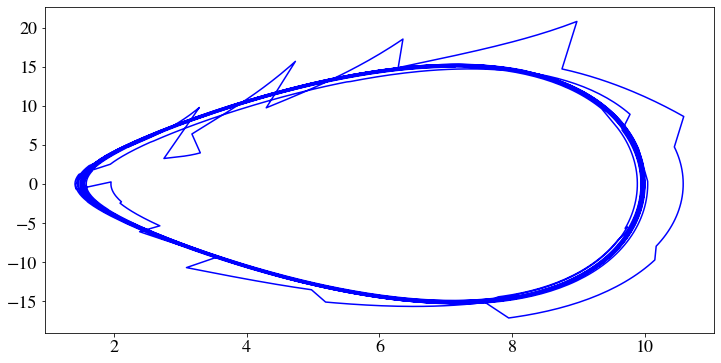

In [27]:
fig, ax = plt.subplots(4,1, figsize=(14, 12), sharex=True, layout="constrained")

#ax[0].plot(observation_times[1:], observations[1:, 0], label='Observations', color='b',  marker="x",
#           alpha=0.5, linestyle="", markersize=5, markeredgewidth=1.5)
ax[0].plot(time_prediction, estimates[:, 0], label='EnKF Estimates', color='r')

ax[0].plot(time_prediction, estimates[:, 0]+3*np.sqrt(Pmat[:,0,0]), color='g', 
          linestyle="--", alpha=0.5)
ax[0].plot(time_prediction, estimates[:, 0]-3*np.sqrt(Pmat[:,0,0]), color='g',
          linestyle="--", alpha=0.5, label=r"$\pm 3\sigma_d$")

#ax[0].fill_between(range(len(estimates[:,0])), estimates[:, 0]+np.sqrt(Pmat[:,0,0]), 
#                  estimates[:, 0]-np.sqrt(Pmat[:,0,0]),
#                     facecolor='yellow', alpha=0.2, interpolate=True)
ax[0].legend(loc="upper right", fontsize=20)
#ax[0].set_ylim((0,12))
ax[1].set_xlim((0, 10)) 
ax[0].set_ylabel(r"$a$")

ax[1].plot(time_prediction, estimates[:, 1], label='EnKF Estimates', color='r')
ax[1].plot(time_prediction, estimates[:, 1]+3*np.sqrt(Pmat[:,1,1]), color='g', 
          linestyle="--" , alpha=0.5)
ax[1].plot(time_prediction, estimates[:, 1]-3*np.sqrt(Pmat[:,1,1]), color='g',
          linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)

ax[1].plot(observation_times[1:], observations[1:], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
ax[1].legend(loc="upper right", fontsize=20)
ax[1].set_ylabel(r"$\dot{a}$")
ax[1].set_ylim((-20,20))

colours = ["r", "b", "g"]
param_labels = [r"$\mu$", r"$\sigma$"]
for i in range(2):
    ax[i+2].plot(time_prediction, np.ones(estimates.shape[0])*true_params[i], "--k", 
                label="True")
    ax[i+2].plot(time_prediction, estimates[:,i+2], c="r", label = param_labels[i]) 
    ax[i+2].plot(time_prediction, estimates[:, i+2]+3*np.sqrt(Pmat[:,i+2,i+2]), color='g', 
          linestyle="--" , alpha=0.5)
    ax[i+2].plot(time_prediction, estimates[:, i+2]-3*np.sqrt(Pmat[:,i+2,i+2]), color='g',
              linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)
    ax[i+2].legend(loc="upper right", fontsize=20) 
ax[2].set_ylabel(r"$\mu$")
ax[3].set_ylabel(r"$\sigma$")
ax[3].set_xlabel(r"$t$")
plt.savefig("enkf_rewritten_figures/ANAC/single_state_measurement_poor_constraint.pdf", 
            bbox_inches="tight") 
